In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tools.ImageOperate import hist_cut, hist_remap, clahe_equalize, pyr_down

(571, 855, 3)


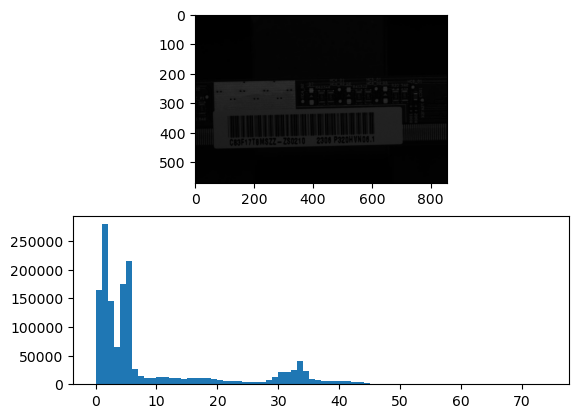

In [31]:
file = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1\C83F17T8MSZZZS0210_NG_BarCode_Camera3_0211100946.jpg'
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
image_pydown = pyr_down(image_source)
print(image_pydown[-1].shape)
# plt.figure(dpi=200)
plt.subplot(2, 1, 1)
plt.imshow(image_pydown[-1])
plt.subplot(2, 1, 2)
plt.hist(image_pydown[-1].ravel(), np.max(image_pydown[-1]), [0, np.max(image_pydown[-1])])
plt.show()

Function hist_cut took 13.09ms to run


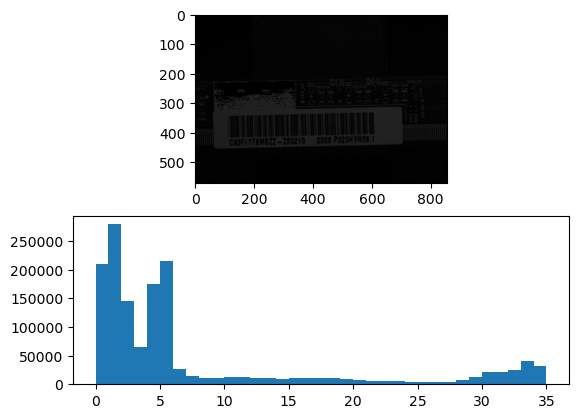

In [32]:
image_cut = hist_cut(image_pydown[-1], 750)
plt.subplot(2, 1, 1)
plt.imshow(image_cut)
plt.subplot(2, 1, 2)
plt.hist(image_cut.ravel(), np.max(image_cut), [0, np.max(image_cut)])
plt.show()

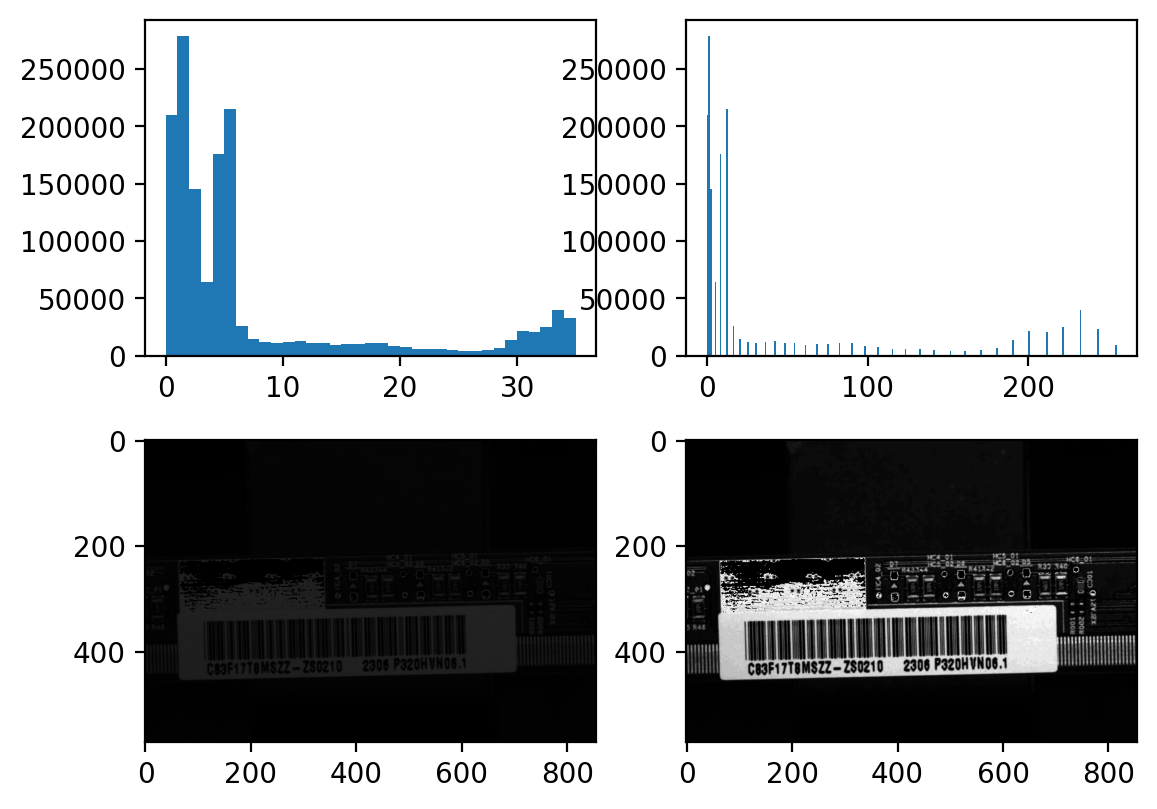

In [36]:
# Contrast stretching
# equ = cv2.normalize(image_cut, None, 0, 255, cv2.NORM_MINMAX)

# Gamma correction
gamma = np.log(255) / np.log(np.max(image_cut))
equ = np.power(image_cut, gamma).astype(np.uint8)


# 绘制原始图像的灰度直方图和更改分布后的灰度直方图
plt.figure(dpi=200)
plt.subplot(2, 2, 1)
plt.hist(image_cut.ravel(), np.max(image_cut), [0, np.max(image_cut)])
plt.subplot(2, 2, 2)
plt.hist(equ.ravel(), np.max(equ), [0, np.max(equ)])

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image_cut, cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(equ, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
# Adaptive histogram equalization:
# Load the image
path = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1'
for index, item in enumerate(os.listdir(path)):
	file = os.path.join(path, item)
	if os.path.isfile(file):
		image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
		try:
			image_pydown = pyr_down(image_source)
			image_cut = hist_cut(image_pydown[-1], 750)
			gamma = np.log(255) / np.log(np.max(image_cut))
			equ = np.power(image_cut, gamma).astype(np.uint8)
		finally:
			filename = os.path.splitext(item)
			new_name = filename[0] + filename[-1]
			result_path = os.path.join(path, 'image_equ')
			if not os.path.exists(result_path):
				os.makedirs(result_path)
			cv2.imwrite(os.path.join(result_path, new_name), image_cut)
print('finished!')
